<a href="https://colab.research.google.com/github/Kameneses/transfer-learning-class/blob/main/notebooks/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning and fine-tuning

En este notebook se aprenderá a clasificar imágenes de perros y gatos mediante el aprendizaje por transferencia. Para ello haremos uso de un modelo previamente entrenado.

Un modelo previamente entrenado es una red guardada que se entrenó previamente en un gran conjunto de datos. Puede utilizar el modelo preentrenado tal cual o utilizar el aprendizaje por transferencia para personalizar este modelo para una tarea determinada.

La intuición detrás del aprendizaje por transferencia para la clasificación de imágenes es que si un modelo se entrena en un conjunto de datos lo suficientemente grande y general, este modelo servirá efectivamente como un modelo genérico del mundo visual. Luego, puede aprovechar estos mapas de características aprendidos sin tener que comenzar desde cero entrenando un modelo grande en un conjunto de datos grande.

En este cuaderno, probará dos formas de personalizar un modelo preentrenado:

* Extracción de características: use las representaciones aprendidas por una red anterior para extraer características significativas de nuevas muestras. Simplemente agregue un nuevo clasificador, que se entrenará desde cero, sobre el modelo preentrenado para que pueda reutilizar los mapas de características aprendidos previamente para el conjunto de datos.

 No es necesario reentrenar todo el modelo. La red convolucional base ya contiene características que son genéricamente útiles para clasificar imágenes. Sin embargo, la parte final de clasificación del modelo preentrenado es específica de la tarea de clasificación original y, posteriormente, específica del conjunto de clases en las que se entrenó el modelo.

* Ajuste fino: Descongele algunas de las capas superiores de una base de modelo congelada y entrene conjuntamente tanto las capas de clasificador recién agregadas como las últimas capas del modelo base. Esto nos permite "ajustar" las representaciones de características de orden superior en el modelo base para hacerlas más relevantes para la tarea específica.

Seguirás el flujo de trabajo general de aprendizaje automático.

* Examinar y comprender los datos
* Cree una canalización de entrada, en este caso utilizando Keras ImageDataGenerator
* Componga el modelo
* Carga en el modelo base preentrenado (y pesos preentrenados)
* Apila las capas de clasificación en la parte superior
* Entrena el modelo
* Evaluar modelo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Preprocesado

### Descarga

En este tutorial, utilizará un conjunto de datos que contiene varios miles de imágenes de perros y gatos. Descargar y extraer un archivo zip que contiene las imágenes, a continuación, crear una `tf.data.Dataset` para el entrenamiento y validación mediante `tf.keras.utils.image_dataset_from_directory`. Se puede obtener más información sobre la carga de imágenes en este [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Muestre las primeras nueve imágenes y etiquetas del conjunto de capacitación:

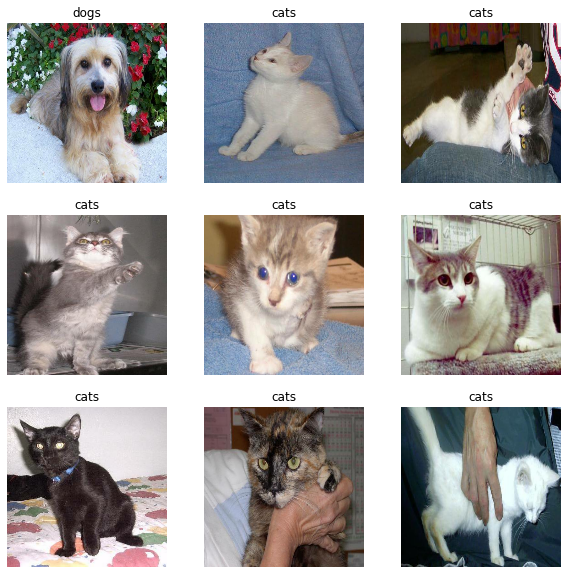

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Como el conjunto de datos original no contiene un conjunto de prueba, crearemos uno. Para ello, determinar cómo están disponibles en el conjunto de validación usando muchos lotes de datos `tf.data.experimental.cardinality` , a continuación, pasar el 20% de ellos a un conjunto de prueba.



In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configurar el conjunto de datos para el rendimiento

Utilice la captación previa en búfer para cargar imágenes desde el disco sin que la E / S se bloquee. Para obtener más información sobre este método de ver 
[data performance](https://www.tensorflow.org/guide/data_performance).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

Cuando no tiene un conjunto de datos de imágenes grande, es una buena práctica introducir artificialmente diversidad de muestras aplicando transformaciones aleatorias, pero realistas, a las imágenes de entrenamiento, como rotación y volteo horizontal. Esto ayuda a exponer el modelo a diferentes aspectos de la formación de datos y reducir el [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

> Estas capas están activos sólo durante el entrenamiento, cuando se llama `model.fit`. Están inactivos cuando el modelo se utiliza en el modo de inferencia en `model.evaulate` o `model.fit`.



Apliquemos repetidamente estas capas a la misma imagen y veamos el resultado.

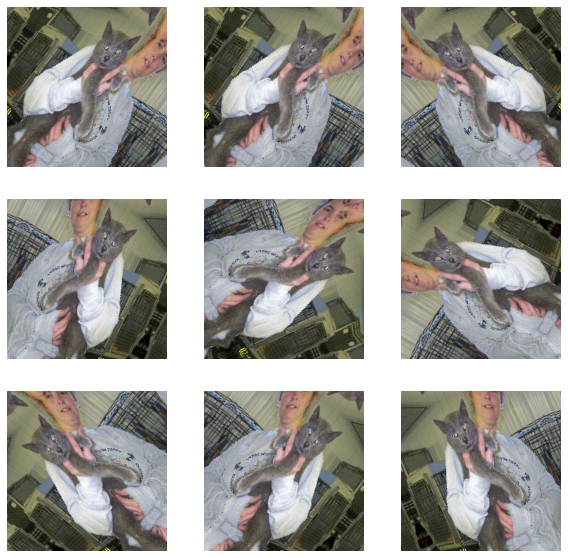

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Cambiar la escala de los valores de píxeles

En un momento, se descarga `tf.keras.applications.MobileNetV2` para usarlo como modelo base. Este modelo espera que los valores de píxeles estén en la escala `[-1, 1]` , pero los valores de los píxeles en las nuevas imagenes están en `[0, 255]` . Para cambiar su escala, utilice el método de preprocesamiento incluido con el modelo.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


> Como alternativa, puede cambiar la escala de valores de los píxeles de `[0, 255]` a `[-1, 1]` usando `tf.keras.layers.Rescaling .




In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)



> Nota: Si está utilizando otros `tf.keras.applications` , asegúrate de revisar la documentación del API para determinar si esperan píxeles en `[-1, 1]` o `[0, 1]`.



## Crea el modelo base a partir de convnets previamente entrenados

Vamos a crear el modelo base del modelo **MobileNet V2** desarrollado por Google. Éste está preentrenado en el conjunto de datos ImageNet, un gran conjunto de datos que consta de 1,4 millones de imágenes y 1000 clases. IMAGEnet es una formación de datos de investigación con una amplia variedad de categorías como `jackfruit` y `syringe` . Esta base de conocimiento nos ayudará a clasificar perros y gatos a partir de nuestro conjunto de datos específico.

Primero, debe elegir qué capa de MobileNet V2 usará para la extracción de características. La última capa de clasificación ("superior", ya que la mayoría de los diagramas de modelos de aprendizaje automático van de abajo hacia arriba) no es muy útil. En su lugar, seguirá la práctica común de depender de la última capa antes de la operación de aplanar. Esta capa se denomina "capa de cuello de botella". Las características de la capa de cuello de botella conservan más generalidad en comparación con la capa final / superior.

Primero, cree una instancia de un modelo MobileNet V2 precargado con pesos entrenados en ImageNet. Al especificar `include_top = false` como argumento, se carga una red que no incluye las capas de clasificación en la parte superior, que es ideal para la extracción de características.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


Este extractor de características convierte cada `160x160x3` imagen en un `5x5x1280 bloque de características. Veamos qué le hace a un lote de imágenes de ejemplo:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Extracción de características

En este paso, congelará la base convolucional creada en el paso anterior y la utilizará como extractor de características. Además, agrega un clasificador encima y entrena al clasificador de nivel superior.

### Congelar la base convolucional

Es importante congelar la base convolucional antes de compilar y entrenar el modelo. La congelación (al establecer layer.trainable = False) evita que los pesos de una capa determinada se actualicen durante el entrenamiento. MobileNet V2 tiene muchas capas, por lo que establecer la totalidad del modelo trainable en False congelará todos ellos.

In [ ]:
base_model.trainable = False

### Nota importante sobre las capas de BatchNormalization

Muchos modelos contienen capas `tf.keras.layers.BatchNormalization`. Esta capa es un caso especial y se deben tomar precauciones en el contexto de fine tuning, como se muestra más adelante en este tutorial.

Cuando se establece `layer.trainable = False` , la capa `BatchNormalization` se ejecutará en modo de inferencia, y no actualizará sus estadísticas de media y varianza.

Al descongelar un modelo que contiene capas `BatchNormalizatio` con el fin de hacer el ajuste fino, debe mantener las capas `BatchNormalizatio` en modo de inferencia mediante el paso `training = False` cuando se llama el modelo base. De lo contrario, las actualizaciones aplicadas a los pesos no entrenables destruirán lo que ha aprendido el modelo.

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Agregar un encabezado de clasificación

Para generar predicciones a partir del bloque de características, promedio de los espaciales `5x5` ubicaciones espaciales, utilizando una capa `tf.keras.layers.GlobalAveragePooling2`  para convertir las características.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplicar una capa `tf.keras.layers.Dense` para convertir estas características en una sola predicción por imagen. Usted no necesita una función de activación aquí porque esta predicción será tratado como un `logit `. Los números positivos predicen la clase 1, los números negativos predicen la clase 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Construir un modelo encadenando junto al aumento de datos, cambio de escala, las capas base_model y extractor de características utilizando la API funcional de Keras . Como se mencionó anteriormente, el uso `training=False` como nuestro modelo contiene una BatchNormalization capa.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compila el modelo

Compile el modelo antes de entrenarlo. Puesto que hay dos clases, utilice el `tf.keras.losses.BinaryCrossentropy` pérdida con `from_logits=True` ya que el modelo proporciona una salida lineal.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Los parámetros de 2,5 M en `MobileNet` están congelados, pero hay 1.2K parámetros entrenables en la capa densa. Estos se dividen entre dos `tf.Variable objetos`, los pesos y sesgos.

In [ ]:
len(model.trainable_variables)

2

### Entrena el modelo

Después de entrenar durante 10 épocas, debería ver una precisión de ~ 94% en el conjunto de validación.


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 67ms/step - loss: 0.9718 - accuracy: 0.3527


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.97
initial accuracy: 0.35


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 10s 97ms/step - loss: 0.7988 - accuracy: 0.5065 - val_loss: 0.6602 - val_accuracy: 0.5879
Epoch 2/10
63/63 [==============================] - 6s 92ms/step - loss: 0.5803 - accuracy: 0.6580 - val_loss: 0.4714 - val_accuracy: 0.7537
Epoch 3/10
63/63 [==============================] - 6s 90ms/step - loss: 0.4601 - accuracy: 0.7610 - val_loss: 0.3601 - val_accuracy: 0.8403
Epoch 4/10
63/63 [==============================] - 6s 92ms/step - loss: 0.3821 - accuracy: 0.8225 - val_loss: 0.2903 - val_accuracy: 0.8874
Epoch 5/10
63/63 [==============================] - 6s 92ms/step - loss: 0.3365 - accuracy: 0.8510 - val_loss: 0.2404 - val_accuracy: 0.9183
Epoch 6/10
63/63 [==============================] - 6s 91ms/step - loss: 0.2860 - accuracy: 0.8795 - val_loss: 0.2027 - val_accuracy: 0.9381
Epoch 7/10
63/63 [==============================] - 6s 91ms/step - loss: 0.2654 - accuracy: 0.8860 - val_loss: 0.1826 - val_accuracy: 0.9443
Epoch 8/10
6

### Curvas de aprendizaje

Echemos un vistazo a las curvas de aprendizaje de la precisión / pérdida de entrenamiento y validación cuando se utiliza el modelo base de MobileNet V2

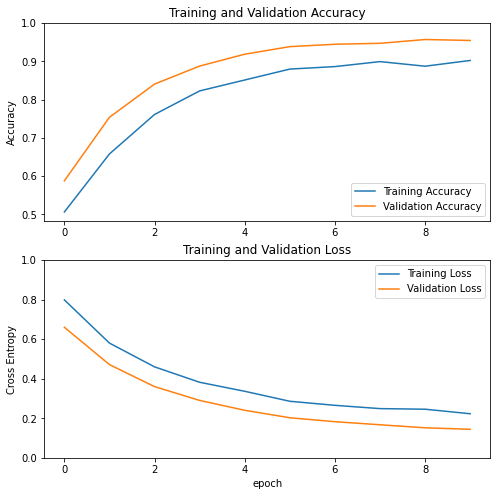

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



> Si se preguntan por qué las métricas de validación son claramente mejores que las métricas de entrenamiento, el principal factor que se debe a que las capas como `tf.keras.layers.BatchNormalization` y `tf.keras.layers.Dropout` afectan a la precisión durante el entrenamiento. Se desactivan al calcular la pérdida de validación.
En menor medida, también se debe a que las métricas de entrenamiento informan el promedio de una época, mientras que las métricas de validación se evalúan después de la época, por lo que las métricas de validación ven un modelo que se ha entrenado un poco más.







## Ajuste fino

En el experimento de extracción de características, solo estaba entrenando algunas capas sobre un modelo base de MobileNet V2. Los pesos de la red entrenada previamente no se actualizaron durante el entrenamiento.

Una forma de aumentar aún más el rendimiento es entrenar (o "ajustar") los pesos de las capas superiores del modelo previamente entrenado junto con el entrenamiento del clasificador que agregó. El proceso de entrenamiento obligará a ajustar las ponderaciones de los mapas de características genéricas a las características asociadas específicamente con el conjunto de datos.

Además, debe intentar ajustar una pequeña cantidad de capas superiores en lugar de todo el modelo de MobileNet. En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que asciende, las características son cada vez más específicas del conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para trabajar con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

### Descongele las capas superiores del modelo

Todo lo que necesita hacer es descongelar la base_model y establezca las capas inferiores de ser un-entrenable. Luego, debe volver a compilar el modelo (necesario para que estos cambios surtan efecto) y reanudar el entrenamiento.


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compila el modelo

Como está entrenando un modelo mucho más grande y desea readaptar los pesos preentrenados, es importante utilizar una tasa de aprendizaje más baja en esta etapa. De lo contrario, su modelo podría sobreajustarse muy rápidamente.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

### Continuar entrenando el modelo

Si se entrenó para la convergencia antes, este paso mejorará su precisión en algunos puntos porcentuales.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 17s 139ms/step - loss: 0.1598 - accuracy: 0.9310 - val_loss: 0.0574 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 8s 120ms/step - loss: 0.1256 - accuracy: 0.9475 - val_loss: 0.0526 - val_accuracy: 0.9740
Epoch 12/20
63/63 [==============================] - 8s 118ms/step - loss: 0.1063 - accuracy: 0.9575 - val_loss: 0.0532 - val_accuracy: 0.9740
Epoch 13/20
63/63 [==============================] - 8s 119ms/step - loss: 0.0928 - accuracy: 0.9645 - val_loss: 0.0459 - val_accuracy: 0.9765
Epoch 14/20
63/63 [==============================] - 8s 119ms/step - loss: 0.0964 - accuracy: 0.9610 - val_loss: 0.0455 - val_accuracy: 0.9777
Epoch 15/20
63/63 [==============================] - 8s 120ms/step - loss: 0.0791 - accuracy: 0.9675 - val_loss: 0.0355 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 8s 121ms/step - loss: 0.0747 - accuracy: 0.9700 - val_loss: 0.0528 - val_accuracy: 0.986

Echemos un vistazo a las curvas de aprendizaje del entrenamiento y la precisión / pérdida de validación al ajustar las últimas capas del modelo base de MobileNet V2 y entrenar al clasificador sobre él. La pérdida de validación es mucho mayor que la pérdida de entrenamiento, por lo que es posible que se produzca un sobreajuste.

También puede obtener un ajuste excesivo, ya que el nuevo conjunto de entrenamiento es relativamente pequeño y similar a los conjuntos de datos originales de MobileNet V2.

Después de un ajuste fino, el modelo casi alcanza el 98% de precisión en el conjunto de validación.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

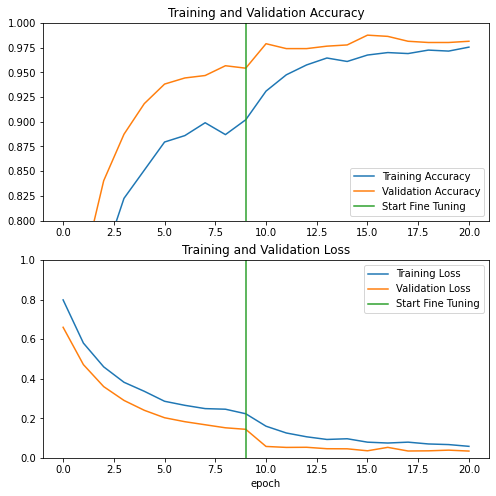

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluación y predicción

Por último, puede verificar el rendimiento del modelo en nuevos datos utilizando el conjunto de prueba.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 68ms/step - loss: 0.0389 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Y ahora está listo para usar este modelo para predecir si su mascota es un gato o un perro.

Predictions:
 [1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0]
Labels:
 [1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0]


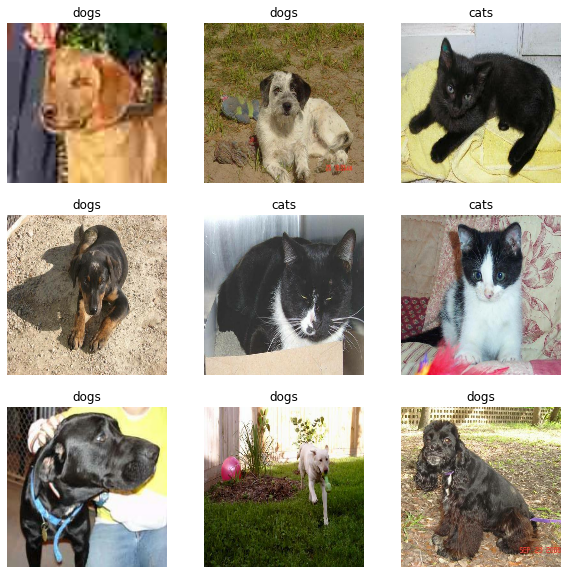

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Resumen

* **El uso de un modelo de pre-formados para la extracción de características**: Cuando se trabaja con un pequeño conjunto de datos, es una práctica común para aprovechar las características aprendidas por un modelo entrenado en un mayor conjunto de datos en el mismo dominio. Esto se hace creando una instancia del modelo previamente entrenado y agregando un clasificador completamente conectado en la parte superior. El modelo preentrenado se "congela" y solo los pesos del clasificador se actualizan durante el entrenamiento. En este caso, la base convolucional extrajo todas las características asociadas con cada imagen y usted solo entrenó un clasificador que determina la clase de imagen dado ese conjunto de características extraídas.

* **Ajuste de un modelo de pre-formación**: Para mejorar aún más el rendimiento, uno podría querer cambiar la finalidad de las capas de nivel superior de los modelos pre-formado para el nuevo conjunto de datos a través de puesta a punto. En este caso, ajustó sus pesos de manera que su modelo aprendiera características de alto nivel específicas del conjunto de datos. Esta técnica generalmente se recomienda cuando el conjunto de datos de entrenamiento es grande y muy similar al conjunto de datos original en el que se entrenó el modelo previamente entrenado.

Para obtener más información, visite la guía de [aprendizaje de transferencia](https://www.tensorflow.org/guide/keras/transfer_learning).
